In [18]:
import pickle
import numpy as np
import scqubits
from scqubits.core.discretization import Grid1d
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from copy import deepcopy
from CoupledQuantumSystems.systems import TransmonOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems
from datetime import datetime
import cupy
import time
from IPython.display import clear_output

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

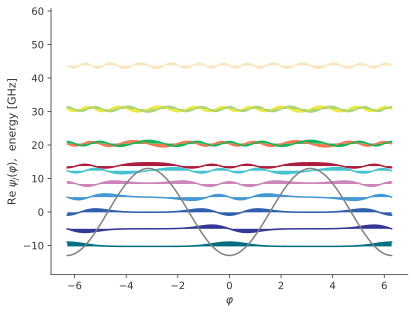

In [2]:
max_ql = 30
max_ol = 100
EJ = 13
EC = 0.3
ng = 0.0
ncut = 50
qbt = scqubits.Transmon(EJ=EJ, EC=EC, ng=ng,ncut=ncut,truncated_dim=max_ql)
qbt.plot_wavefunction(which = list(range(12)),
                      phi_grid=Grid1d(min_val=-2*np.pi,max_val=2*np.pi,pt_count=100),
                      scaling=0.5)

In [3]:
qbt.eigenvals(10)-qbt.eigenvals(10)[0]

array([ 0.        ,  5.26674561, 10.18371638, 14.71003604, 18.63892983,
       22.6007086 , 23.98831075, 30.62961774, 30.68015993, 41.00731365])

(<Figure size 640x480 with 2 Axes>, <Axes: >)

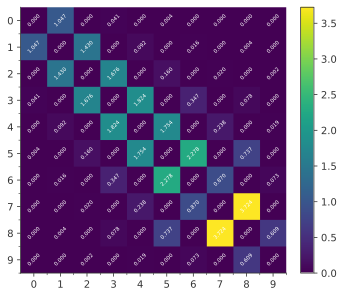

In [4]:
qbt.plot_matrixelements(operator='n_operator',
                        evals_count=10,
                        show3d=False,
                        show_numbers=True)

In [5]:
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)

Er loop:   0%|          | 0/100 [00:00<?, ?it/s]RuntimeWarning: divide by zero encountered in scalar divide
 /tmp/ipykernel_157934/1747159573.py: 2RuntimeWarning: invalid value encountered in scalar subtract
Er loop: 100%|██████████| 100/100 [00:00<00:00, 131647.96it/s]


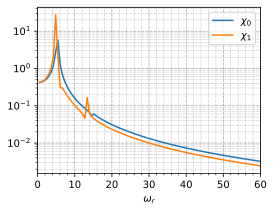

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

matrix = qbt.n_operator(energy_esys=True)
evals = qbt.eigenvals()
Er_list = np.linspace(0,60,100)
qls = [0,1]
ylim=(-2,2)
num_evals =len(evals)

for ql  in qls:
    shift_from_qubit_transition = []
    for Er in tqdm(Er_list, desc = "Er loop"):
        shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(num_evals)] 
        shift_from_qubit_transition.append(sum(shifts))
    shift_from_qubit_transition = np.abs(shift_from_qubit_transition)
    ax.plot(Er_list, shift_from_qubit_transition, label=rf'$\chi_{ql}$')

ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_xlim(Er_list[0],Er_list[-1])
# ax.set_ylim(ylim[0],ylim[1])
ax.set_xlabel(rf'$\omega_r$')
ax.set_yscale('log')
ax.legend()

# All right let's do adiabatic labeling

## First let's do a benchmark for cupy diagonalization`

In [ ]:
max_ql = 30
max_ol = 100
EJ = 13
EC = 0.3
ng = 0.0
ncut = 50
qbt = scqubits.Transmon(EJ=EJ, EC=EC, ng=ng,ncut=ncut,truncated_dim=max_ql)
qbt.plot_wavefunction(which = list(range(12)),
                      phi_grid=Grid1d(min_val=-2*np.pi,max_val=2*np.pi,pt_count=100),
                      scaling=0.5)

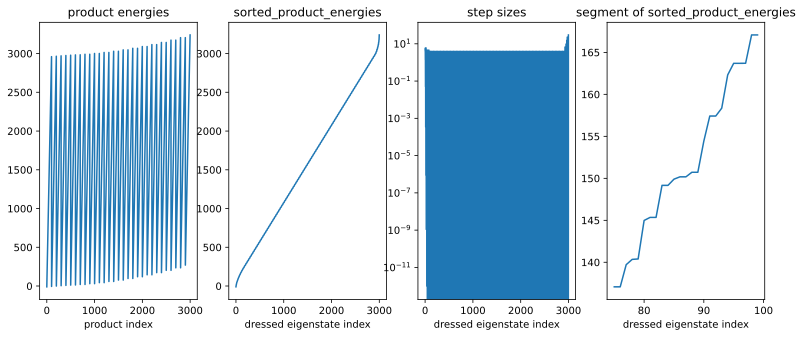

In [63]:
qbt_evals = qbt.eigenvals(evals_count = max_ql)
resonator_energies = Er * np.arange(max_ol)
product_energies = np.array([qbt_evals[ql] + resonator_energies[ol] for ql in range(max_ql) for ol in range(max_ol)])
sorted_product_energies = np.sort(product_energies)
step_sizes = np.diff(sorted_product_energies)
fig,axes = plt.subplots(1,4,figsize=(13,5))
axes[0].plot(product_energies)
axes[0].set_xlabel('product index')
axes[0].set_title('product energies')
axes[1].plot(sorted_product_energies)
axes[1].set_xlabel('dressed eigenstate index')
axes[1].set_title('sorted_product_energies')
axes[2].plot(step_sizes)
axes[2].set_xlabel('dressed eigenstate index')
axes[2].set_yscale('log')
axes[2].set_title('step sizes')
axes[3].plot(list(range(75,100)),sorted_product_energies[75:100])
axes[3].set_xlabel('dressed eigenstate index')
axes[3].set_title('segment of sorted_product_energies')
plt.show()


In [8]:
g = 0
Er = 30
kappa = 0.01

osc = scqubits.Oscillator(E_osc=Er, truncated_dim=max_ol, l_osc=1.0)

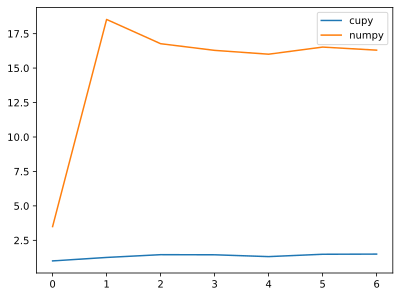

In [13]:
g_arr = [0,1,2,3,4,5,6]
cupy_time = [1.0055716037750244,
 1.2564692497253418,
 1.4571382999420166,
 1.449399471282959,
 1.3168559074401855,
 1.4874837398529053,
 1.4988508224487305]
np_time = [3.4963643550872803,
 18.530452728271484,
 16.770527601242065,
 16.28702187538147,
 16.008582592010498,
 16.52496576309204,
 16.302200078964233]
for  g in tqdm(g_arr,desc='g loop'):
    hilbertspace = scqubits.HilbertSpace([qbt, osc])
    hilbertspace.add_interaction(g_strength=g, op1=qbt.n_operator, op2=osc.n_operator, add_hc=False)
    hamiltonian_np = hilbertspace.hamiltonian().full()
    time_start = time.time()
    hamiltonian_cupy = cupy.array(hamiltonian_np)
    cupy_evals, cupy_evecs = cupy.linalg.eigh(hamiltonian_cupy)
    cupy_time.append(time.time() - time_start)

    time_start = time.time()
    evals, evecs = np.linalg.eigh(hamiltonian_np)
    np_time.append(time.time() - time_start)
    assert np.allclose(evals, cupy_evals)
plt.plot(g_arr,cupy_time,label='cupy')
plt.plot(g_arr,np_time,label='numpy')
plt.legend()
plt.show()

In [43]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import linear_sum_assignment

def match_eigenvectors_with_confidence(vecs_old, vecs_new):
    """
    Match 'vecs_new' to 'vecs_old' via maximum overlap and compute a confidence score.
    
    Parameters
    ----------
    vecs_old : np.ndarray, shape (dim, dim)
        The eigenvectors from the previous step (columns = eigenvectors).
    vecs_new : np.ndarray, shape (dim, dim)
        The eigenvectors from the new step.
    
    Returns
    -------
    perm : np.ndarray of shape (dim,)
        The permutation that best matches new vectors to old vectors.
    confidence : float
        A measure of how well the new vectors match the old ones,
        e.g. the average or minimum matched overlap.
    overlap_matrix : np.ndarray of shape (dim, dim)
        Absolute overlaps between old and new vectors.
    """
    # Compute absolute overlap matrix
    overlap_matrix = cupy.abs(vecs_old.T.conj() @ vecs_new).get()
    
    # We want to MAXIMIZE total overlap -> linear_sum_assignment does MINIMIZE cost
    cost = -overlap_matrix
    row_ind, col_ind = linear_sum_assignment(cost)
    # row_ind should be [0,1,2,...,dim-1], col_ind is the permutation
    
    perm = col_ind
    
    # Extract the matched overlaps on the diagonal (old i matched to new perm[i])
    matched_overlaps = overlap_matrix[row_ind, col_ind]
    
    # Confidence metric: here we use the minimum matched overlap,
    # but you could also use np.mean(matched_overlaps).
    
    
    return perm, matched_overlaps, overlap_matrix

def adaptive_g_sweep(
    g_start=0.0,
    g_end=10.0,
    initial_step=1e-8,
    min_conf_threshold=0.9,
    max_steps=2000,
    enlarge_step_factor=1.2,
    reduce_step_factor=0.5,
    output_folder="eigen_data",
    store_data=True
):
    """
    Adiabatically sweep 'g' from g_start to g_end, adaptively adjusting steps based on
    eigenvector matching confidence. Stores all eigenvalues/eigenvectors on disk,
    but does NOT keep them all in memory.

    We only keep in memory:
      - The last (old) eigenvectors (for matching)
      - The final accepted eigenvectors
    Everything else is written to disk and not retained in memory.

    Parameters
    ----------
    H0 : np.ndarray
        Base Hamiltonian.
    H_coupling : np.ndarray
        Interaction term to be scaled by g.
    g_start, g_end : float
        Sweep range for g.
    initial_step : float
        Initial guess for the step size.
    min_conf_threshold : float
        If matched overlap is below this, reduce step size.
    max_steps : int
        Max number of accepted steps.
    enlarge_step_factor : float
        Factor by which to multiply step size if confidence is well above threshold.
    reduce_step_factor : float
        Factor by which to multiply step size if confidence is below threshold.
    output_folder : str
        Where to store eigenvalues/vectors. Created if doesn't exist.
    store_data : bool
        If True, write NPZ files for each accepted step.

    Returns
    -------
    g_trajectory : list of float
        The accepted g-values in ascending order.
    final_eigvals : np.ndarray, shape (dim,)
        The eigenvalues for the final g.
    final_eigvecs : np.ndarray, shape (dim, dim)
        The eigenvectors for the final g, aligned to the second-to-last step.
    """
    def get_esys(g):
        hilbertspace = scqubits.HilbertSpace([qbt, osc])
        hilbertspace.add_interaction(g_strength=g, op1=qbt.n_operator, op2=osc.n_operator, add_hc=False)
        hamiltonian_np = hilbertspace.hamiltonian().full()
        hamiltonian_cupy = cupy.array(hamiltonian_np)
        cupy_evals, cupy_evecs = cupy.linalg.eigh(hamiltonian_cupy)
        return cupy_evals, cupy_evecs
    if store_data:
        import os
        os.makedirs(output_folder, exist_ok=True)

    # 1) Diagonalize at g_start
    g_current = g_start
    step_size = initial_step
    
    vals_init, vecs_init =  get_esys(g_current)
    idx_init = np.argsort(vals_init)
    vals_old = vals_init[idx_init]
    vecs_old = vecs_init[:, idx_init]

    # Save the trajectory of accepted g-values
    g_trajectory = [g_current]

    # Optionally store to disk
    if store_data:
        fname = os.path.join(output_folder, f"g_{g_current:.3e}.npz")
        np.savez(fname, vals=vals_old, vecs=vecs_old)

    accepted_steps = 1

    # We'll keep track only of the latest accepted eigenvals/vecs in memory
    final_eigvals = vals_old
    final_eigvecs = vecs_old

    # 2) Adiabatic stepping loop
    while g_current < g_end and accepted_steps < max_steps:
        g_candidate = g_current + step_size
        if g_candidate > g_end:
            g_candidate = g_end

        # clear_output(wait=True)
        print(f'g_current: {g_current:.3e}, g_candidate: {g_candidate:.3e}, step_size: {step_size:.3e}')

        # Diagonalize at g_candidate
        vals_cand, vecs_cand = get_esys(g_candidate)
        idx_cand = np.argsort(vals_cand)
        vals_cand = vals_cand[idx_cand]
        vecs_cand = vecs_cand[:, idx_cand]

        # Match new eigenvectors to old
        perm, matched_overlaps, overlap_matrix = match_eigenvectors_with_confidence(vecs_old, vecs_cand)

        # Reorder
        vals_cand = vals_cand[perm]
        vecs_cand = vecs_cand[:, perm]

        # Check confidence
        confidence = np.min(matched_overlaps)
        plt.plot(matched_overlaps)
        plt.show()
        if confidence < min_conf_threshold:
            print(f"Confidence {confidence} fell below {min_conf_threshold}, reducing step size.")
            # Overlap too small -> reduce step
            step_size *= reduce_step_factor
            if step_size < 1e-12:
                print(f"Step size {step_size} fell below 1e-12, aborting.")
                break
        else:
            # Accept step
            g_current = g_candidate
            g_trajectory.append(g_current)
            accepted_steps += 1

            # Update old references
            vecs_old = vecs_cand
            final_eigvals = vals_cand
            final_eigvecs = vecs_cand

            # Store to disk
            if store_data:
                fname = os.path.join(output_folder, f"g_{g_current:.3e}.npz")
                np.savez(fname, vals=vals_cand, vecs=vecs_cand)

            # Possibly enlarge step if confidence is well above threshold
            if confidence > (min_conf_threshold + 0.03):
                step_size *= enlarge_step_factor

        if np.isclose(g_current, g_end, atol=1e-12):
            break

    # Return minimal in-memory data: the list of g-values, plus the final (vals, vecs)
    return g_trajectory, final_eigvals, final_eigvecs

g_current: 0.000e+00, g_candidate: 1.000e-08, step_size: 1.000e-08


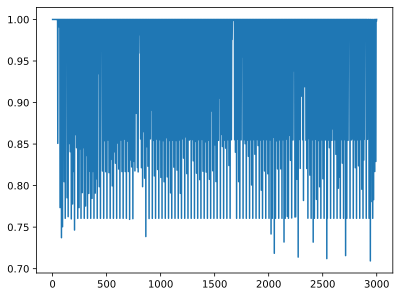

Confidence 0.7093396627674277 fell below 0.9, reducing step size.
g_current: 0.000e+00, g_candidate: 5.000e-09, step_size: 5.000e-09


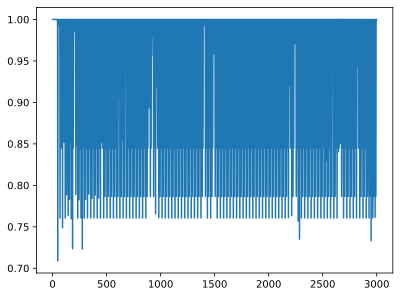

Confidence 0.7088689177355317 fell below 0.9, reducing step size.
g_current: 0.000e+00, g_candidate: 2.500e-09, step_size: 2.500e-09


KeyboardInterrupt: 

In [44]:
g_trajectory, final_eigvals, final_eigvecs = adaptive_g_sweep()

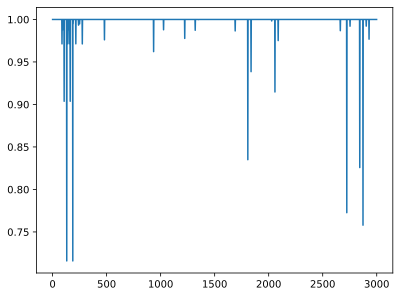

In [50]:
def get_esys(g):
    hilbertspace = scqubits.HilbertSpace([qbt, osc])
    hilbertspace.add_interaction(g_strength=g, op1=qbt.n_operator, op2=osc.n_operator, add_hc=False)
    hamiltonian_np = hilbertspace.hamiltonian().full()
    hamiltonian_cupy = cupy.array(hamiltonian_np)
    cupy_evals, cupy_evecs = cupy.linalg.eigh(hamiltonian_cupy)
    return cupy_evals, cupy_evecs

vals1, vecs1 = get_esys(0.0)
vals2, vecs2 = get_esys(1e-12)
perm, matched_overlaps, overlap_matrix = match_eigenvectors_with_confidence(vecs1, vecs2)
plt.plot(matched_overlaps)
plt.show()



In [ ]:

system  =  TransmonOscillatorSystem(
                qbt = qbt,
                Er = Er,
                g_strength = g,
                kappa=kappa,
                max_ql = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(15) for ol in range(max_ol) ],
                )

In [8]:
id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_qbt_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
qbt_creation_arr = id_wrapped_qbt_destory.dag().full()
qbt_destory_arr= id_wrapped_qbt_destory.full()

resonator_ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)
qubit_ladder_overlap = system.get_ladder_overlap_arr(qbt_creation_arr)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f'resonator_ladder_overlap_large_g_{timestamp}.pkl', 'wb') as f:
    pickle.dump(resonator_ladder_overlap,f)
with open(f'qubit_ladder_overlap_large_g_{timestamp}.pkl', 'wb') as f:
    pickle.dump(qubit_ladder_overlap,f)

overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):       
        if ql == 0 and ol == 0:
            overlap_idx_arr[ql,ol] = 0
        elif ol ==0:
            overlap_idx_arr[ql,ol] = np.argmax(qubit_ladder_overlap[:,overlap_idx_arr[ql-1,ol]])
        else:
            overlap_idx_arr[ql,ol] = np.argmax(resonator_ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

for ql in range(max_ql):
    for ol in range(max_ol):
        system.product_to_dressed[(ql,ol)] =  overlap_idx_arr[ql,ol] 


In [55]:
system.set_sign_multiplier()
system.set_new_product_to_keep([[ql, ol] for ql in range(15) for ol in range(max_ol) ])
system.set_new_operators_after_setting_new_product_to_keep()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f'syste_large_g_{timestamp}.pkl', 'wb') as f:
    pickle.dump(system,f)

Text(0.5, 0, 'flattened product index')

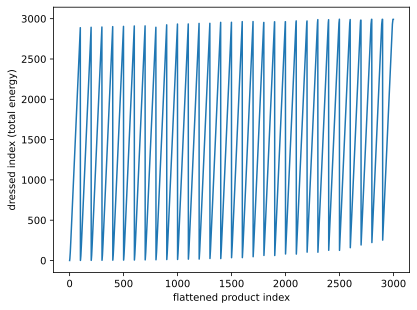

In [56]:
plt.plot(overlap_idx_arr.flatten())
plt.ylabel('dressed index (total energy)')
plt.xlabel('flattened product index')
# plt.ylim(0,100)

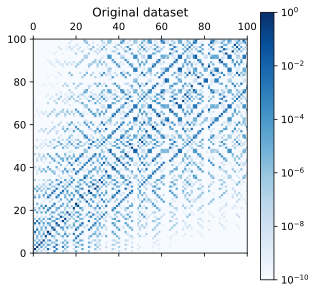

In [41]:
from matplotlib.colors import LogNorm
plt.matshow(qubit_ladder_overlap, cmap=plt.cm.Blues,norm=LogNorm(vmin=1e-10,vmax=1))
plt.title("Original dataset")
plt.colorbar()
plt.xlim(0,100)
plt.ylim(0,100)
_ = plt.show()


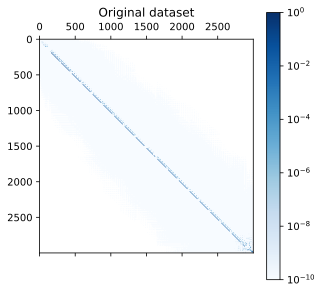

In [33]:
from matplotlib.colors import LogNorm
plt.matshow(resonator_ladder_overlap, cmap=plt.cm.Blues,norm=LogNorm(vmin=1e-10,vmax=1))
plt.title("Original dataset")
plt.colorbar()
_ = plt.show()


In [44]:
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

model = SpectralCoclustering(n_clusters=max_ql, random_state=0,)
model.fit(resonator_ladder_overlap)

# # Compute the similarity of two sets of biclusters
# score = consensus_score(
#     model.biclusters_, (rows[:, row_idx_shuffled], columns[:, col_idx_shuffled])
# )
# print(f"consensus score: {score:.1f}")


SpectralCoclustering(n_clusters=30, random_state=0)

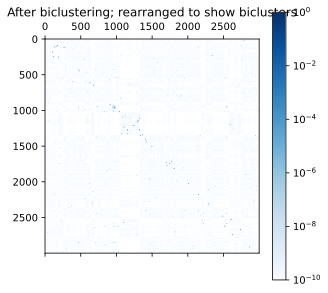

In [45]:
reordered_rows = resonator_ladder_overlap[np.argsort(model.row_labels_)]
reordered_data = reordered_rows[:, np.argsort(model.column_labels_)]

plt.matshow(reordered_data, cmap=plt.cm.Blues,norm=LogNorm(vmin=1e-10,vmax=1))
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
_ = plt.show()


In [58]:
sorted_overlap_idx_arr = np.sort(overlap_idx_arr.flatten())
for i in range(len(overlap_idx_arr.flatten())):
    if i != sorted_overlap_idx_arr[i]:
        print(i,sorted_overlap_idx_arr[i])
        


48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 69
68 70
69 71
70 72
71 73
72 74
73 75
74 76
75 77
76 78
77 79
78 80
79 81
80 82
81 83
82 84
83 85
84 86
85 87
86 88
87 89
88 90
89 91
90 93
91 94
92 95
93 96
94 97
95 98
96 99
97 100
98 101
99 102
100 103
101 104
102 105
103 106
104 107
105 108
106 109
107 110
108 111
109 112
110 113
111 114
112 115
113 116
114 118
115 119
116 120
117 121
118 122
119 123
120 124
121 125
122 126
123 127
124 128
125 129
126 130
127 131
128 132
129 133
130 134
131 135
132 136
133 137
134 138
135 139
136 140
137 141
138 142
139 143
140 145
141 146
142 147
143 148
144 149
145 150
146 151
147 152
148 153
149 154
150 155
151 156
152 157
153 158
154 159
155 161
156 162
157 163
158 164
159 165
160 166
161 167
162 168
163 169
164 170
165 171
166 172
167 174
168 175
169 176
170 177
171 178
172 179
173 180
174 181
175 182
176 183
177 184
178 185
179 186
180 187
181 188
182 190
183 191
184 192
185 1

In [19]:
def get_photon_number(state):
    state_after_a = resonator_destory_arr @ state
    return np.abs(np.sum(state_after_a**2).real)
def get_qbt_number(state):
    state_after_a = qbt_destory_arr @ state
    return np.abs(np.sum(state_after_a**2).real)

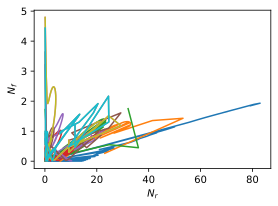

In [20]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(max_ql))


for ql in list(range(10)):

    photon_num_arr = np.zeros((max_ol))
    qbt_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        photon_num_arr[ol] = get_photon_number(system.evecs[overlap_idx_arr[ql][ol]].full())
        qbt_num_arr[ol] = get_qbt_number(system.evecs[overlap_idx_arr[ql][ol]].full())

    ax.plot(photon_num_arr,qbt_num_arr,label=f'{ql}')

# ax.set_ylim(0,4)
# ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()
fig.savefig('hybridization.pdf')

In [16]:
with open('syste.pkl', 'rb') as f:
    system = pickle.load(f)

In [21]:
system.evals[ system.product_to_dressed[(0,1)] ] - system.evals[ system.product_to_dressed[(0,0)] ], \
system.evals[ system.product_to_dressed[(1,1)] ] - system.evals[ system.product_to_dressed[(1,0)] ]

(30.166837743242848, 30.13501769042925)

In [13]:
state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

leakage_products_to_keep = [[ql, ol] for ql in [0] for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in [1,2] for ol in range(150) ]
list_of_products_to_keep = [
    leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]


list_of_systems = []
list_of_kwargs = []
for products_to_keep, y0 in zip(list_of_products_to_keep, initial_states):
    system.set_new_product_to_keep(products_to_keep)
    system.set_new_operators_after_setting_new_product_to_keep()
    list_of_systems.append(deepcopy(system))
    list_of_kwargs.append( {
        'y0':system.truncate_function(y0) ,
        'tlist':tlist,
        'drive_terms':[DriveTerm( 
                            driven_op= system.driven_operator,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_shape_args={
                                'w_d': w_d ,
                                'amp': amp,
                                't_rise': 20,
                                't_square': tot_time
                            })],
        'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
        # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
        })
    

results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
    list_of_systems,
    list_of_kwargs,
    post_processing = ['pad_back']
)

import pickle
with open('sesolve_small_dim_a015_tomo.pkl', 'wb') as file:
    pickle.dump(results, file)


 Total run time: 290.89s*] Elapsed 290.89s / Remaining 00:00:00:00 [*********43%           ] Elapsed 126.09s / Remaining 00:00:02:47
 [*********98%***********] Elapsed 290.96s / Remaining 00:00:00:05

Processing states with pad_back_custom:   7%|▋         | 29/400 [00:00<00:04, 79.35it/s]

 [*********99%***********] Elapsed 291.27s / Remaining 00:00:00:02

Processing states with pad_back_custom:  16%|█▌        | 63/400 [00:00<00:04, 78.21it/s]

 [********100%***********] Elapsed 291.76s / Remaining 00:00:00:00

Processing states with pad_back_custom:  20%|█▉        | 79/400 [00:01<00:04, 71.68it/s]

 [*********99%***********] Elapsed 292.04s / Remaining 00:00:00:02

Processing states with pad_back_custom:  24%|██▍       | 96/400 [00:01<00:04, 73.18it/s]

 [*********99%***********] Elapsed 292.41s / Remaining 00:00:00:02

Processing states with pad_back_custom:  28%|██▊       | 112/400 [00:01<00:04, 71.57it/s]

 Total run time: 292.50s*] Elapsed 292.50s / Remaining 00:00:00:00
 [*********98%***********] Elapsed 292.55s / Remaining 00:00:00:05

Processing states with pad_back_custom:   6%|▌         | 23/400 [00:00<00:05, 66.79it/s]]

 [*********99%***********] Elapsed 292.96s / Remaining 00:00:00:02

Processing states with pad_back_custom:  14%|█▍        | 55/400 [00:00<00:04, 73.72it/s]]

 [*********98%***********] Elapsed 293.32s / Remaining 00:00:00:05

Processing states with pad_back_custom:   0%|          | 0/400 [00:00<?, ?it/s]0.21it/s]]

 Total run time: 293.70s*] Elapsed 293.70s / Remaining 00:00:00:00
 [*********99%***********] Elapsed 293.80s / Remaining 00:00:00:02

Processing states with pad_back_custom:  57%|█████▋    | 229/400 [00:03<00:02, 73.66it/s]

 [*********99%***********] Elapsed 294.13s / Remaining 00:00:00:02

Processing states with pad_back_custom:  40%|███▉      | 158/400 [00:02<00:03, 72.28it/s]

 [********100%***********] Elapsed 294.76s / Remaining 00:00:00:00

Processing states with pad_back_custom:  47%|████▋     | 188/400 [00:02<00:03, 62.98it/s]

 [*********60%**         ] Elapsed 295.02s / Remaining 00:00:03:16

Processing states with pad_back_custom:  34%|███▍      | 136/400 [00:01<00:03, 69.52it/s]

 Total run time: 295.41s*] Elapsed 295.41s / Remaining 00:00:00:00


Processing states with pad_back_custom:   0%|          | 0/400 [00:00<?, ?it/s]73.40it/s]

 Total run time: 295.77s*] Elapsed 295.77s / Remaining 00:00:00:00
 [*********99%***********] Elapsed 295.89s / Remaining 00:00:00:02

Processing states with pad_back_custom:  67%|██████▋   | 269/400 [00:03<00:01, 73.55it/s]

 [*********60%**         ] Elapsed 296.18s / Remaining 00:00:03:17

Processing states with pad_back_custom:  80%|████████  | 321/400 [00:04<00:01, 78.14it/s]

 [********100%***********] Elapsed 296.70s / Remaining 00:00:00:00

Processing states with pad_back_custom:  66%|██████▋   | 266/400 [00:03<00:01, 74.67it/s]

 Total run time: 297.37s*] Elapsed 297.37s / Remaining 00:00:00:00


Processing states with pad_back_custom:  55%|█████▌    | 221/400 [00:02<00:02, 78.46it/s]

 [*********61%**         ] Elapsed 298.31s / Remaining 00:00:03:10

Processing states with pad_back_custom:  37%|███▋      | 149/400 [00:01<00:03, 80.27it/s]

 [*********61%**         ] Elapsed 299.25s / Remaining 00:00:03:11

Processing states with pad_back_custom:  56%|█████▌    | 222/400 [00:02<00:02, 82.13it/s]

 [*********61%**         ] Elapsed 300.12s / Remaining 00:00:03:11

Processing states with pad_back_custom:  74%|███████▎  | 294/400 [00:03<00:01, 81.72it/s]

 [*********62%**         ] Elapsed 301.03s / Remaining 00:00:03:04

Processing states with pad_back_custom:  92%|█████████▏| 366/400 [00:04<00:00, 87.38it/s]

 [*********62%**         ] Elapsed 301.88s / Remaining 00:00:03:05

Processing states with pad_back_custom: 100%|██████████| 400/400 [00:04<00:00, 82.21it/s]


 Total run time: 478.48s*] Elapsed 478.48s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]


In [22]:
with open('sesolve_small_dim_a015_tomo.pkl', 'rb') as file:
    results = pickle.load(file)

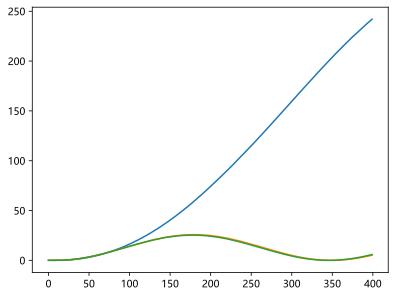

In [14]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])

(345.0, 350.0)

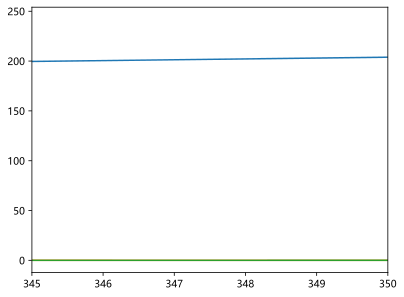

In [15]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])
plt.xlim(345,350)
# plt.ylim(0,0.01)

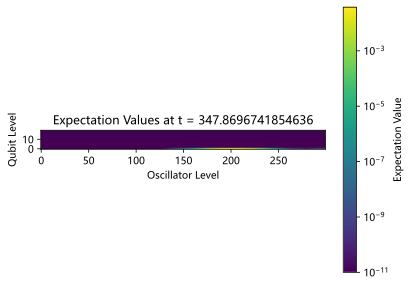

In [16]:
from CoupledQuantumSystems.visualization import *
plot_heatmap(results[0],347,system.product_to_dressed,max_ql,max_ol,LogNorm())

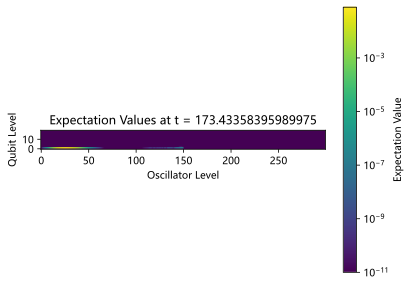

In [17]:
plot_heatmap(results[1],int(347/2),system.product_to_dressed,max_ql,max_ol,LogNorm())

In [20]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized

def convert_dressed_to_product_vectorized(system, states, products_to_keep, num_processes=None, update_products_to_keep=True):
    if update_products_to_keep:
        system.set_new_product_to_keep(products_to_keep)
        system.set_new_operators_after_setting_new_product_to_keep()

    if num_processes is None:
        num_processes = multiprocessing.cpu_count()

    # Multiprocessing, vectorized
    partial_function = partial(get_product_vectorized,
                               pad_back_custom=system.pad_back_function,
                               product_to_dressed=system.product_to_dressed,
                               sign_multiplier_vector=system.sign_multiplier_vector)

    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the iterator to show the progress
        product_states = list(tqdm(pool.imap(partial_function, states), total=len(states), desc="Processing States"))

    return product_states


for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
    result.states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
                                                                           states= result.states,
                                                                            products_to_keep = products_to_keep,
                                                                            num_processes = 14
                                                                                    )
with open('sesolve_small_dim_a015_tomo_product.pkl', 'wb') as f:
    pickle.dump(results,f)

Processing States: 100%|██████████| 400/400 [03:19<00:00,  2.01it/s]


In [5]:
with open('sesolve_small_dim_a015_tomo_product.pkl', 'rb') as f:
    results = pickle.load(f)

t loop: 100%|██████████| 400/400 [00:00<00:00, 458.62it/s]


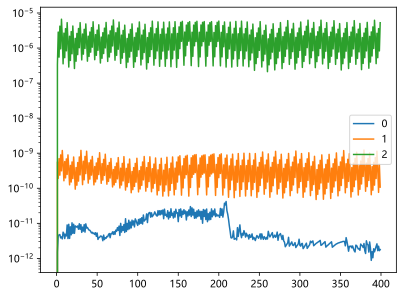

In [21]:
leakage_arr = np.zeros(shape=(3,len(tlist)))
for ql,result in zip([0,1,2],[results[0],results[1],results[2]]):
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = result.states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[ql,t_idx] = 1-qutip.expect(op, rho_qbt)

for ql in [0,1,2]:
    plt.plot(leakage_arr[ql],label=f'{ql}')
plt.legend()
plt.yscale('log')

In [6]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


In [7]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(1,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 1,2) for result in results[1:]]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])
    

fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')


Processing:  23%|██▎       | 92/400 [00:04<00:16, 18.59it/s]


KeyboardInterrupt: 

In [6]:
# state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    # state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

# leakage_products_to_keep = [[ql, ol] for ql in range(10) for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in range(10) for ol in range(150) ]
list_of_products_to_keep = [
    # leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]


# list_of_systems = []
# list_of_kwargs = []
# for products_to_keep, y0 in zip(list_of_products_to_keep, initial_states):
#     system.set_new_product_to_keep(products_to_keep)
#     system.set_new_operators_after_setting_new_product_to_keep()
#     list_of_systems.append(deepcopy(system))
#     list_of_kwargs.append( {
#         'y0':system.truncate_function(y0) ,
#         'tlist':tlist,
#         'drive_terms':[DriveTerm( 
#                             driven_op= system.driven_operator,
#                             pulse_shape_func=square_pulse_with_rise_fall,
#                             pulse_shape_args={
#                                 'w_d': w_d ,
#                                 'amp': amp,
#                                 't_rise': 20,
#                                 't_square': tot_time
#                             })],
#         'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
#         # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
#         })
    

# results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
#     list_of_systems,
#     list_of_kwargs,
#     post_processing = ['pad_back']
# )

# import pickle
# with open('sesolve_large_dim_a015_tomo.pkl', 'wb') as file:
#     pickle.dump(results, file)


In [3]:
import pickle
with open('sesolve_large_dim_a015_tomo.pkl', 'rb') as file:
    results = pickle.load(file)


In [9]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized

def convert_dressed_to_product_vectorized(system, states, products_to_keep, num_processes=None, update_products_to_keep=True):
    if update_products_to_keep:
        system.set_new_product_to_keep(products_to_keep)
        system.set_new_operators_after_setting_new_product_to_keep()

    if num_processes is None:
        num_processes = multiprocessing.cpu_count()

    # Multiprocessing, vectorized
    partial_function = partial(get_product_vectorized,
                               pad_back_custom=system.pad_back_function,
                               product_to_dressed=system.product_to_dressed,
                               sign_multiplier_vector=system.sign_multiplier_vector)

    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the iterator to show the progress
        product_states = list(tqdm(pool.imap(partial_function, states), total=len(states), desc="Processing States"))

    return product_states


# for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
#     result.states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
#                                                                            states= result.states,
#                                                                             products_to_keep = products_to_keep,
#                                                                             num_processes = 18
#                                                                                     )
# with open('sesolve_large_dim_a015_tomo_product.pkl', 'wb') as f:
#     pickle.dump(results,f)


for i, result, products_to_keep in zip([0,1,2,3,4,5][5:],results[5:], list_of_products_to_keep[5:]):
    states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
                                                                           states= result.states,
                                                                            products_to_keep = products_to_keep,
                                                                            num_processes = 14
                                                                                    )
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'wb') as f:
        pickle.dump(states_in_product_basis,f)

Processing States: 100%|██████████| 400/400 [03:40<00:00,  1.81it/s]


t loop: 100%|██████████| 400/400 [00:13<00:00, 29.21it/s]


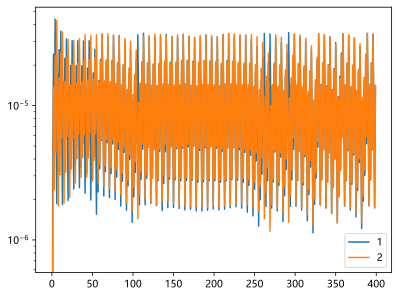

In [11]:
leakage_arr = np.zeros(shape=(2,len(tlist)))
for ql in [1,2]:
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    with open(f'sesolve_large_dim_a015_tomo_product_part{ql-1}.pkl', 'rb') as f:
        states_in_product_basis = pickle.load(f)
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[ql-1,t_idx] = 1-qutip.expect(op, rho_qbt)

for ql in [1,2]:
    plt.plot(leakage_arr[ql-1],label=f'{ql}')
plt.legend()
plt.yscale('log')

In [4]:
for i, result in zip([0,1,2,3,4,5],results):
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'rb') as f:
        states_in_product_basis = pickle.load(f)
    result.states_in_product_basis = states_in_product_basis

In [5]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


In [8]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(1,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 1,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])

Processing: 100%|██████████| 400/400 [02:24<00:00,  2.78it/s]


Text(0.5, 1.0, 'infidelity')

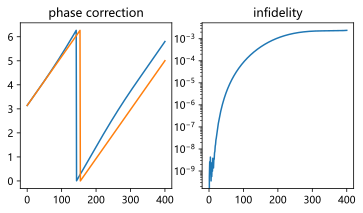

In [9]:
    
fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].plot(tlist,original_phase)

axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')

In [10]:
with open(f'sesolve_large_dim_a015_tomo_infidelity.pkl', 'wb') as f:
    pickle.dump(infidelity,f)

In [ ]:
leakage_arr = np.zeros(shape=(6,len(tlist)))
initial_qbt_state = qutip.basis(max_ql,  1)
op = initial_qbt_state * initial_qbt_state.dag()
for i in [0,1,2,3,4,5]:
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = results[i].states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[i,t_idx] = 1-qutip.expect(op, rho_qbt)

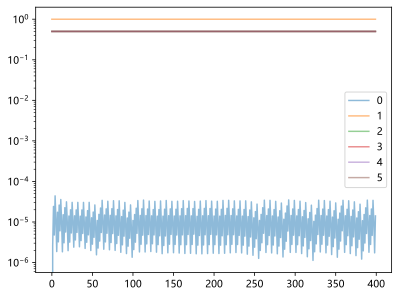

: 

In [14]:
for i in [0,1,2,3,4,5]:
    plt.plot(leakage_arr[i],label=f'{i}',alpha=0.5)
plt.legend()
plt.yscale('log')